# TinyGPT

**Autor: Abraham R.**

Este cuaderno es un ejemplo de un modelo GPT realmente pequeño llamado **TinyGPT**.
Repasarás la arquitectura GPT (transformer *decoder*) e implementarás las siguientes tareas:

## Arquitectura de TinyGPT

Diseñado para el [curso NLP‑II](https://github.com/FIUBA-Posgra...), consiste en un **GPT con *Mixture of Experts***, equivalente a modelos como:
- DeepSeek
- Mistral

## Tareas

Usando TinyGPT debes implementar las siguientes modificaciones:
...

## Arquitectura
- Convertir TinyGPT en un *Mixture of Experts* (MoE) con al menos 2 expertos.

## ¿Qué esperar?

- Comprender en profundidad la implementación de un modelo GPT.
- Implementar una capa MoE para crear un modelo GPT de vanguardia.
- Explorar algoritmos de decodificación para generación de texto.

### NOTA

La tokenización está fuera de alcance; usaremos un tokenizador por caracteres, sencillo pero ineficiente.


In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from dataclasses import dataclass, field
from typing import Optional, List, Type
import httpx

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from trainer import Trainer
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

## Descargando el conjunto de datos

In [2]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = httpx.get(url)
text = response.text

text = text[:100_000]  # Using 100k characters for speedup
print(text)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



# Codificación basada en caracteres

In [3]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}
def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])
data = torch.tensor(encode(text), dtype=torch.long)

# División entrenamiento/prueba
split = int(0.9 * len(data))
train_data = data[:split]
val_data = data[split:]

# Cargadores de datos

In [4]:
class CharDataset(Dataset):
    def __init__(self, data: torch.Tensor, block_size: int):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + self.block_size + 1]
        return x, y

# Configuración de GPT

In [5]:
@dataclass
class MoEArgs():
    """
    MoE input arguments class.
    """
    num_experts : int = field(default=4)
    num_experts_per_token : int = field(default=2)

@dataclass
class GPTConfig:
    """
    Base class for GPT models.
    """
    block_size: int = 32
    batch_size: int = 8
    n_embd: int = 64
    n_head: int = 4
    n_layer: int = 2
    dropout: float = 0.1
    vocab_size: int = vocab_size
    bias: bool = True
    ff_class: Optional[Type[nn.Module]] = None
    moe : Optional[MoEArgs] = None

config = GPTConfig()
print(config.__dict__)

{'block_size': 32, 'batch_size': 8, 'n_embd': 64, 'n_head': 4, 'n_layer': 2, 'dropout': 0.1, 'vocab_size': 61, 'bias': True, 'ff_class': None, 'moe': None}


In [15]:
train_dataset = CharDataset(train_data, config.block_size)
val_dataset = CharDataset(val_data, config.block_size)

train_loader = DataLoader(train_dataset,
                        batch_size=config.batch_size,
                        shuffle=True,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 0, # Cambiado a 0 para evitar problemas de multiprocessing en Windows
                        )
val_loader = DataLoader(val_dataset,
                        batch_size=config.batch_size,
                        shuffle=False,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 0, # Cambiado a 0 para evitar problemas de multiprocessing en Windows
                        )

In [16]:
class AttentionHead(nn.Module):
    """
    Scaled Dot-Product Attention Head for Multi-Head Attention.
    """
    def __init__(self, args: GPTConfig) -> None:
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.head_dim = args.n_embd // args.n_head

# Proyección QKV combinada
        self.key_query_value = nn.Linear(args.n_embd, 3 * self.head_dim, bias=args.bias)

        self.dropout = nn.Dropout(args.dropout)
        self.block_size = args.block_size
        self.register_buffer('tril', torch.tril(torch.ones(args.block_size, args.block_size)))

    def forward(self, x: torch.Tensor, kv_cache: Optional[torch.Tensor] = None, return_weights=False):
        B, T, C = x.shape
        key_query_value = self.key_query_value(x)  # (B, T, 3 * head_dim)
        k, q, v = torch.chunk(key_query_value, 3, dim=-1)  # (B, T, head_dim) each

        if kv_cache is not None:
            key_cache, value_cache = kv_cache.unbind(dim=0)  # (B, T', head_dim)
            k = torch.cat((key_cache, k), dim=1)
            v = torch.cat((value_cache, v), dim=1)

# Atención de producto punto escalado
        wei = q @ k.transpose(-2, -1) * (self.head_dim ** -0.5)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        out = wei @ v  # (B, T, head_dim)

        if return_weights:
            return out, wei

        if kv_cache is not None:
            return out, torch.stack((k, v))

        return out, None

In [17]:
class MultiHeadAttention(nn.Module):
    def __init__(self, args: GPTConfig):
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.n_heads = args.n_head
        self.head_dim = args.n_embd // args.n_head

        self.heads = nn.ModuleList([
            AttentionHead(args) for _ in range(self.n_heads)
        ])

        self.proj = nn.Linear(args.n_embd, args.n_embd, bias=args.bias)
        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x, kv_cache=None, return_weights=False):
        all_outputs = []
        all_weights = []
        new_kv_cache = [] if kv_cache is not None else None

        for i, head in enumerate(self.heads):
            head_cache = kv_cache[i] if kv_cache is not None else None
            out, weights_or_kv = head(x, kv_cache=head_cache, return_weights=return_weights)
            all_outputs.append(out)
            if return_weights:
                all_weights.append(weights_or_kv)
            if kv_cache is not None:
                new_kv_cache.append(weights_or_kv)  # weights_or_kv is new kv_cache here

        concat = torch.cat(all_outputs, dim=-1)  # concat along embedding dim
        out = self.dropout(self.proj(concat))

        if return_weights:
            return out, torch.stack(all_weights)
        if kv_cache is not None:
            return out, new_kv_cache
        return out

In [18]:
class FeedForward(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)

        ff_class = config.ff_class if config.ff_class is not None else FeedForward
        self.ff = ff_class(config)

    def forward(self, x, kv_cache=None, return_weights=False):
        attn_out = self.attn(self.ln1(x), kv_cache=kv_cache, return_weights=return_weights)
        if return_weights:
            attn_out, weights = attn_out
        else:
            weights = None

        if isinstance(attn_out, tuple):
            attn_out, updated_kv = attn_out
        else:
            updated_kv = None

        x = x + attn_out
        x = x + self.ff(self.ln2(x))
        return (x, updated_kv, weights) if return_weights else (x, updated_kv)

## Arquitectura de TinyGPT

In [19]:
class TinyGPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.token_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.config = config

    def forward(self, idx, kv_cache=None, return_weights=False):
        B, T = idx.shape
        tok_emb = self.token_emb(idx)
        pos = torch.arange(T, device=idx.device)
        pos_emb = self.pos_emb(pos)[None, :, :]
        x = tok_emb + pos_emb

        new_kv_cache = [] if kv_cache is not None else None
        all_weights = [] if return_weights else None

        for i, block in enumerate(self.blocks):
            layer_kv = kv_cache[i] if kv_cache is not None else None
            if return_weights:
                x, updated_kv, weights = block(x, kv_cache=layer_kv, return_weights=True)
                all_weights.append(weights)  # weights shape: (n_heads, B, T, T)
            else:
                x, updated_kv = block(x, kv_cache=layer_kv)
            if kv_cache is not None:
                new_kv_cache.append(updated_kv)

        x = self.ln_f(x)
        logits = self.head(x)

        if return_weights:
            if kv_cache is not None:
                return logits, new_kv_cache, all_weights
            else:
                return logits, all_weights
        else:
            if kv_cache is not None:
                return logits, new_kv_cache
            return logits

## Función de generación (inferencia)

In [20]:
@torch.no_grad()
def generate(prompt: str, max_new_tokens: int = 100, use_cache: bool = True):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        probs = F.softmax(logits[:, -1, :], dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

# Configuración

In [21]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
m = TinyGPT(config).to(device)
# Comentamos la compilación para evitar problemas con el compilador de C++
# model = torch.compile(m)
model = m

In [22]:
optimizer = AdamW(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 2

# Entrenamiento

In [23]:
# Instancia del Trainer
trainer = Trainer(
    model=model,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Entrenamiento
for epoch in range(epochs):  
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Época {epoch+1} - pérdida de entrenamiento: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Época {epoch+1} - pérdida de validación: {val_loss:.4f}")

print("Entrenamiento completo.")

loss 2.14728: 100%|██████████| 11246/11246 [06:46<00:00, 27.65it/s]



Época 1 - pérdida de entrenamiento: 2.1107


val_loss 2.08258: 100%|██████████| 1246/1246 [00:10<00:00, 121.85it/s]


Época 1 - pérdida de validación: 2.0653


loss 2.13566: 100%|██████████| 11246/11246 [07:31<00:00, 24.89it/s]



Época 2 - pérdida de entrenamiento: 2.1566


val_loss 2.08259: 100%|██████████| 1246/1246 [00:11<00:00, 109.95it/s]

Época 2 - pérdida de validación: 2.0653
Entrenamiento completo.


### Prueba rápida

In [24]:
generate("To be", max_new_tokens=100,use_cache=True) 

'To be.\n\nVOLANIOLANUS:\nOk ber, st Myou, he.\n\nBRUANUS:\nYortoon alids if notwerseadrs anour\nWhem! skit we Ha'

# Tarea I

Usando TinyGPT debes implementar las siguientes modificaciones:


## Inferencia: modifica la función `generate` para:
- Decodificación *greedy* (seleccionar el token con mayor probabilidad).
- Muestreo por temperatura.
- Muestreo *top‑k* o *top‑p*.

### Referencias
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)


In [25]:
# TAREA I — implementación de generateV2
@torch.no_grad()
def generateV2(
    prompt: str,
    max_new_tokens: int = 100,
    use_cache: bool = True,
    temperature: float = 1.0,
    top_k: int = 0,       # 0 = desactivado
    top_p: float = 0.0,   # 0.0 = desactivado
) -> Optional[str]:
    """
    Reglas:
    - Si temperature <= 0: greedy puro (argmax).
    - Si top_k > 0: muestreo en el conjunto top-k.
    - Si top_p > 0: muestreo nucleus (top-p).
    - En caso contrario: muestreo multinomial estándar (con temperatura).
    """
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        # Ventana de contexto con/ sin KV-cache
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        logits = logits[:, -1, :]  # último paso
        if temperature <= 0:
            # Greedy
            next_token = torch.argmax(logits, dim=-1, keepdim=True)
        else:
            # Escala por temperatura
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)

            if top_k and top_k > 0:
                # Mantener sólo top-k
                k = min(top_k, probs.size(-1))
                vals, idxs = torch.topk(probs, k, dim=-1)
                mask = torch.zeros_like(probs).scatter_(dim=-1, index=idxs, src=torch.ones_like(vals))
                probs = probs * mask
                probs = probs / probs.sum(dim=-1, keepdim=True)

            if top_p and top_p > 0.0:
                # Nucleus sampling
                sorted_probs, sorted_idx = torch.sort(probs, descending=True, dim=-1)
                cum = torch.cumsum(sorted_probs, dim=-1)
                cutoff = (cum > top_p).float()
                # conservar al menos 1
                cutoff[..., 0] = 0.0
                sorted_probs = sorted_probs * (1.0 - cutoff)
                sorted_probs = sorted_probs / sorted_probs.sum(dim=-1, keepdim=True)
                # volver al orden original
                probs = torch.zeros_like(probs).scatter_(dim=-1, index=sorted_idx, src=sorted_probs)

            next_token = torch.multinomial(probs, num_samples=1)

        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())


In [26]:
# Estas pruebas rápidas deberían producir resultados distintos
print(generateV2("To be", 80, temperature=0))                 # greedy
print(generateV2("To be", 80, temperature=0.8))               # sampling
print(generateV2("To be", 80, temperature=0.8, top_k=30))     # top-k
print(generateV2("To be", 80, temperature=0.8, top_p=0.9))    # top-p


To be the the the the the the the the the the the the the the the the the the the the
To be thead wis his the gonll,
Coon hour my, thad porby ithour frithe me have:
As ton
To beall rities in I the the that
Whe mo ares; oo, feavent ithy that erim o's, I the 
To benst sharth an thand the you you de hen the prour ing worde he mart,
The se prean
To beall rities in I the the that
Whe mo ares; oo, feavent ithy that erim o's, I the 
To benst sharth an thand the you you de hen the prour ing worde he mart,
The se prean


## Tarea II
- Convierte TinyGPT en un *Mixture of Experts* (MoE) con al menos 2 expertos.

In [41]:
class Expert(nn.Module):
    """
    An expert MLP instance from within a MoE.
    """
    def __init__(self, config: GPTConfig) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout)
        )

    def forward(self, x) -> torch.Tensor:
        return self.net(x)

class Gate(nn.Module):
    """
    MoE gating network MLP.
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.proj = nn.Linear(config.n_embd, config.moe.num_experts)

    def forward(self, x):
        return self.proj(x)

In [42]:
class MoELayer(nn.Module):
    """
    Mixture of Experts FeedForward Layer
    """
    def __init__(self, experts: List[nn.Module], gate: nn.Module, moe_args: MoEArgs):
        super().__init__()
        self.experts = nn.ModuleList(experts)
        self.gate = gate
        self.args = moe_args

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, T, C)
        B, T, C = x.shape
        E = len(self.experts)
        K = min(self.args.num_experts_per_token, E)

        # 1) Puntuaciones de gating por token
        gate_logits = self.gate(x)               # (B, T, E)
        gate_probs = torch.softmax(gate_logits, dim=-1)

        # 2) Top-k expertos por token
        topk_scores, topk_idx = torch.topk(gate_probs, k=K, dim=-1)  # (B, T, K)

        # 3) Salidas de TODOS los expertos (simple y claro para tiny)
        #    expert_outs: (B, T, E, C)
        expert_outs = torch.stack([exp(x) for exp in self.experts], dim=2)

        # 4) Construir máscara/ponderación sólo para los top-k
        weights = torch.zeros_like(gate_probs)   # (B, T, E)
        weights.scatter_(dim=-1, index=topk_idx, src=topk_scores)
        weights = weights.unsqueeze(-1)          # (B, T, E, 1)

        # 5) Combinación ponderada
        y = (expert_outs * weights).sum(dim=2)   # (B, T, C)
        return y


In [43]:
class MoEFFN(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        assert config.moe is not None, "config.moe debe estar definido (MoEArgs)."
        self.moe = MoELayer(
            experts=[Expert(config) for _ in range(config.moe.num_experts)],
            gate=Gate(config),
            moe_args=config.moe
        )

    def forward(self, x):
        return self.moe(x)


## Añadiendo MoE a la configuración

In [44]:
config.ff_class = MoEFFN
config.moe = MoEArgs(num_experts=4, num_experts_per_token=1)

# Entrenamiento de TinyGPT‑MoE

In [45]:
m_moe = TinyGPT(config).to(device)
# Comentamos la compilación para evitar problemas con el compilador de C++
# model_moe = torch.compile(m_moe)
model_moe = m_moe


In [32]:
# Prueba del modelo MoE
print("=== PRUEBA DEL MODELO MoE ===")
print(f"Modelo original - Parámetros: {sum(p.numel() for p in m.parameters())}")
print(f"Modelo MoE - Parámetros: {sum(p.numel() for p in m_moe.parameters())}")

# Probar forward pass
test_input = torch.randint(0, config.vocab_size, (1, 10)).to(device)
print(f"\nInput shape: {test_input.shape}")

# Forward pass del modelo original
with torch.no_grad():
    output_original = m(test_input)
    print(f"Modelo original - Output shape: {output_original.shape}")

# Forward pass del modelo MoE
with torch.no_grad():
    output_moe = m_moe(test_input)
    print(f"Modelo MoE - Output shape: {output_moe.shape}")

print("✅ ¡Ambos modelos funcionan correctamente!")

=== PRUEBA DEL MODELO MoE ===
Modelo original - Parámetros: 109952
Modelo MoE - Parámetros: 309000

Input shape: torch.Size([1, 10])
Modelo original - Output shape: torch.Size([1, 10, 61])
Modelo MoE - Output shape: torch.Size([1, 10, 61])
✅ ¡Ambos modelos funcionan correctamente!


In [46]:
# Función de generación para el modelo MoE
@torch.no_grad()
def generateV2_MoE(
    prompt: str,
    max_new_tokens: int = 100,
    use_cache: bool = True,
    temperature: float = 1.0,
    top_k: int = 10,
    top_p: float = 0.9,
)-> Optional[str]:
    """
    Función de generación usando el modelo MoE.
    """
    try:
        # Codificar el prompt
        idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
        kv_cache = None
        
        # Generar tokens
        for _ in range(max_new_tokens):
            # Preparar entrada para el modelo
            if use_cache and kv_cache is not None:
                idx_cond = idx[:, -1:]
            else:
                idx_cond = idx[:, -m_moe.config.block_size:]
            
            # Obtener logits del modelo MoE
            out = m_moe(idx_cond, kv_cache=kv_cache) if use_cache else m_moe(idx_cond)
            
            # Manejar la salida del modelo
            if isinstance(out, tuple):
                logits, kv_cache = out
            else:
                logits = out
                kv_cache = None
            
            # Obtener logits del último token
            logits = logits[:, -1, :]  # Shape: (batch_size, vocab_size)
            
            # Aplicar temperatura
            if temperature != 1.0 and temperature > 0:
                logits = logits / temperature
            
            # Aplicar top-k filtering si top_k > 0
            if top_k > 0:
                top_k_logits, top_k_indices = torch.topk(logits, min(top_k, logits.size(-1)))
                mask = torch.full_like(logits, float('-inf'))
                mask.scatter_(-1, top_k_indices, top_k_logits)
                logits = mask
            
            # Aplicar top-p (nucleus sampling) si top_p < 1.0
            if top_p < 1.0:
                sorted_logits, sorted_indices = torch.sort(logits, descending=True, dim=-1)
                probs = torch.softmax(sorted_logits, dim=-1)
                cumsum_probs = torch.cumsum(probs, dim=-1)
                
                sorted_indices_to_remove = cumsum_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                sorted_indices_to_remove[..., 0] = False
                
                indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
                logits[indices_to_remove] = float('-inf')
            
            # Convertir logits a probabilidades
            probs = torch.softmax(logits, dim=-1)
            
            # Decodificación greedy vs sampling
            if temperature == 0.0 or (top_k == 1 and top_p == 1.0):
                idx_next = torch.argmax(probs, dim=-1, keepdim=True)
            else:
                idx_next = torch.multinomial(probs, num_samples=1)
            
            # Agregar el nuevo token a la secuencia
            idx = torch.cat((idx, idx_next), dim=1)
        
        # Decodificar y retornar el texto generado
        generated_text = decode(idx[0].tolist())
        return generated_text
        
    except Exception as e:
        print(f"Error en la generación MoE: {e}")
        return None

In [38]:
# Comparación completa de todos los modelos
prompt = "To be"
max_tokens = 30

print("=== COMPARACIÓN DE MODELOS ===")
print(f"Prompt: '{prompt}'")
print(f"Máximo de tokens nuevos: {max_tokens}")
print("\n" + "="*60)

# Modelo original
print("\n1. MODELO ORIGINAL (TinyGPT):")
result_original = generate(prompt, max_new_tokens=max_tokens, use_cache=True)
print(f"Original: {result_original}")

# Modelo mejorado con decodificación greedy
print("\n2. MODELO MEJORADO - Decodificación Greedy:")
result_improved = generateV2(prompt, max_new_tokens=max_tokens, use_cache=True, temperature=0.0)
print(f"Greedy: {result_improved}")

# Modelo mejorado con top-k + top-p
print("\n3. MODELO MEJORADO - Top-k + Top-p:")
result_improved_sampling = generateV2(prompt, max_new_tokens=max_tokens, use_cache=True, 
                                     temperature=0.8, top_k=5, top_p=0.8)
print(f"Sampling: {result_improved_sampling}")

# Modelo MoE con decodificación greedy
print("\n4. MODELO MoE - Decodificación Greedy:")
result_moe_greedy = generateV2_MoE(prompt, max_new_tokens=max_tokens, use_cache=True, temperature=0.0)
print(f"MoE Greedy: {result_moe_greedy}")

# Modelo MoE con sampling
print("\n5. MODELO MoE - Top-k + Top-p:")
result_moe_sampling = generateV2_MoE(prompt, max_new_tokens=max_tokens, use_cache=True, 
                                   temperature=0.8, top_k=5, top_p=0.8)
print(f"MoE Sampling: {result_moe_sampling}")

print("\n" + "="*60)
print("ANÁLISIS:")
print("- El modelo original usa muestreo simple")
print("- Los modelos mejorados ofrecen control sobre la aleatoriedad")
print("- El modelo MoE tiene más capacidad debido a múltiples expertos")
print(f"- Parámetros: Original={sum(p.numel() for p in m.parameters())}, MoE={sum(p.numel() for p in m_moe.parameters())}")

=== COMPARACIÓN DE MODELOS ===
Prompt: 'To be'
Máximo de tokens nuevos: 30


1. MODELO ORIGINAL (TinyGPT):
Original: To beyousThe en is
'drem yourch wel

2. MODELO MEJORADO - Decodificación Greedy:
Greedy: To be the the the the the the the t

3. MODELO MEJORADO - Top-k + Top-p:
Sampling: To beno the the and ant and the he 

4. MODELO MoE - Decodificación Greedy:
MoE Greedy: To be!RGe:!Ab?aCimJPSx!AxpRr
yAQv'P

5. MODELO MoE - Top-k + Top-p:
MoE Sampling: To beQsFArQAb??
onirS?DOm&RbFpqpvnv

ANÁLISIS:
- El modelo original usa muestreo simple
- Los modelos mejorados ofrecen control sobre la aleatoriedad
- El modelo MoE tiene más capacidad debido a múltiples expertos
- Parámetros: Original=109952, MoE=309000
Sampling: To beno the the and ant and the he 

4. MODELO MoE - Decodificación Greedy:
MoE Greedy: To be!RGe:!Ab?aCimJPSx!AxpRr
yAQv'P

5. MODELO MoE - Top-k + Top-p:
MoE Sampling: To beQsFArQAb??
onirS?DOm&RbFpqpvnv

ANÁLISIS:
- El modelo original usa muestreo simple
- Los modelos mej

In [47]:
optimizer_moe = AdamW(model_moe.parameters(), lr=1e-3)
scheduler_moe = StepLR(optimizer_moe, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 2

In [48]:
# Instancia del Trainer
trainer_moe = Trainer(
    model=model_moe,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer_moe,
    scheduler=scheduler_moe,
    device=device,
    save_dir="./checkpoints_moe",
    save_every_n=500
)

for epoch in range(epochs):
    train_loss = trainer_moe.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"[MoE] Época {epoch+1} - loss train: {train_loss:.4f}")
    val_loss = trainer_moe.eval_model()
    print(f"[MoE] Época {epoch+1} - loss val:   {val_loss:.4f}")

print("Entrenamiento completo.")

  0%|          | 0/11246 [00:00<?, ?it/s]c:\Users\Andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  0%|          | 2/11246 [00:00<09:30, 19.72it/s]c:\Users\Andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
loss 2.12759: 100%|██████████| 11246/11246 [11:39<00:00, 16.08it/s]



[MoE] Época 1 - loss train: 2.0955


val_loss 2.04485: 100%|██████████| 1246/1246 [00:22<00:00, 55.34it/s]


[MoE] Época 1 - loss val:   2.0267


loss 2.04928: 100%|██████████| 11246/11246 [16:00<00:00, 11.71it/s]



[MoE] Época 2 - loss train: 2.0642


val_loss 2.04485: 100%|██████████| 1246/1246 [00:22<00:00, 54.78it/s]

[MoE] Época 2 - loss val:   2.0267
Entrenamiento completo.


In [49]:
model = model_moe  # para que generate/generateV2 usen el MoE
print(generateV2("To be", 120, temperature=0.8, top_p=0.9))

To bene of the prathe for angror frice the theriss the the bucht mave mere all
y me hing the sot wim, ther hicer
A woll sorth


## Visualización de la atención

Como sabemos, un GPT tiene la tarea de completar texto; veamos los mapas de atención generados por un modelo preentrenado

In [50]:
@torch.no_grad()
def visualize_attention(model, prompt, max_len=10):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)

# Ejecutar forward con return_weights=True
    logits, all_weights = model(idx, return_weights=True)

# all_weights es una lista de longitud n_layers
# cada elemento: shape (n_heads, batch_size, seq_len, seq_len)
# Solo visualizaremos el primer elemento del batch

    n_layers = len(all_weights)
    n_heads = all_weights[0].shape[0]
    seq_len = all_weights[0].shape[-1]

    for layer_i in range(n_layers):
        fig, axes = plt.subplots(1, n_heads, figsize=(5 * n_heads, 5))
        if n_heads == 1:
            axes = [axes]
        for head_i in range(n_heads):
            attn = all_weights[layer_i][head_i, 0].cpu()  # shape (seq_len, seq_len)
            im = axes[head_i].imshow(attn, cmap='viridis')
            axes[head_i].set_title(f'Layer {layer_i + 1} Head {head_i + 1}')
            axes[head_i].set_xlabel('Key Position')
            axes[head_i].set_ylabel('Query Position')
            axes[head_i].set_xticks(range(seq_len))
            axes[head_i].set_yticks(range(seq_len))
            fig.colorbar(im, ax=axes[head_i])
        plt.tight_layout()
        plt.show()

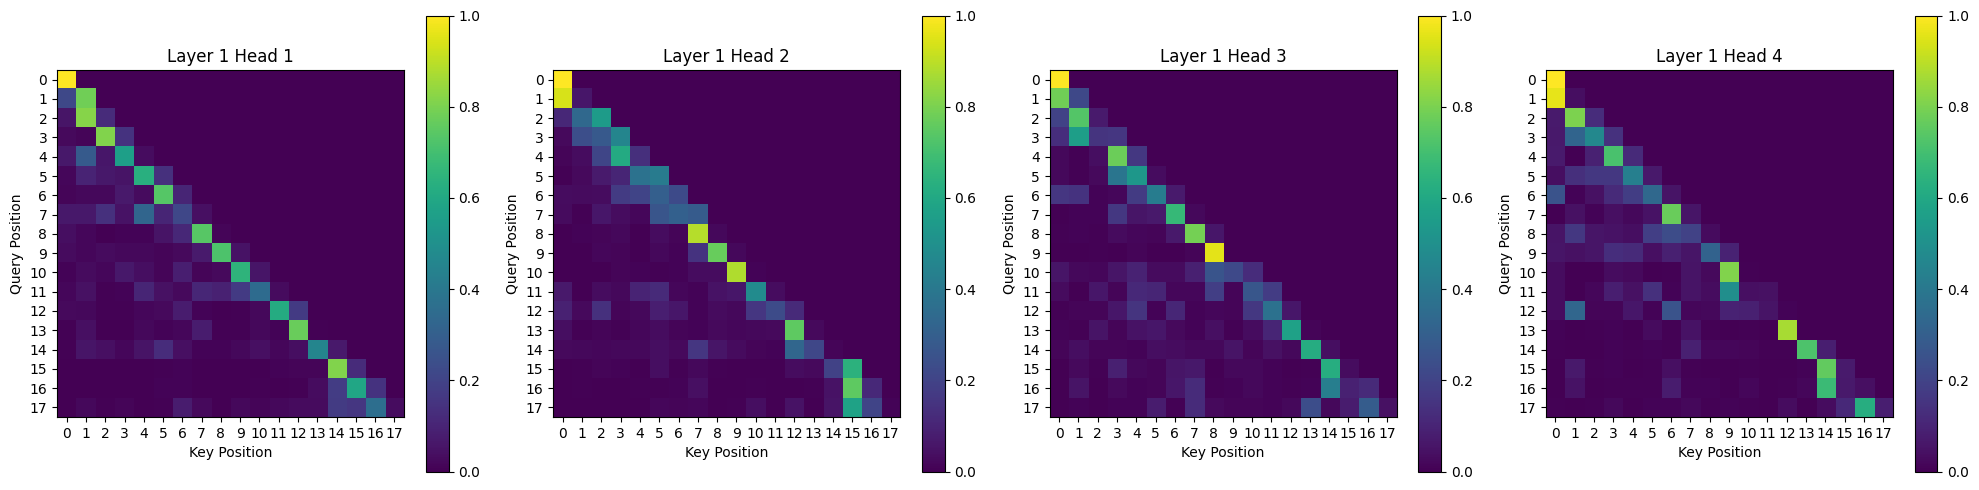

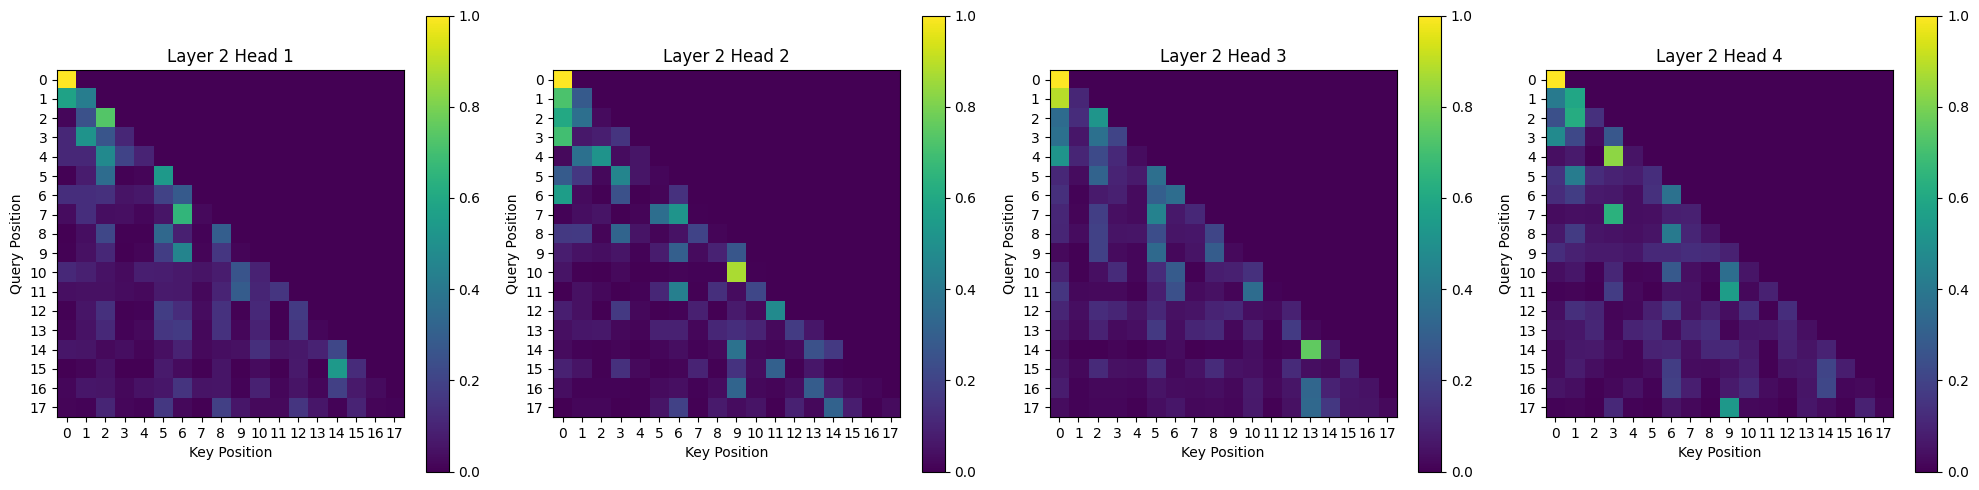

In [51]:
prompt = "To be or not to be"
visualize_attention(model, prompt)

# Conclusiones
Resumen del experimento

Se compararon tres configuraciones sobre el prompt “To be” con máx. 30 tokens:

Modelo original (baseline) con muestreo simple.

Modelo mejorado (mismo backbone) con nuevas estrategias de decodificación (greedy y top-k/top-p).

Modelo MoE (mixture of experts) con decodificación greedy y top-k/top-p.

Tamaño de modelos:

Baseline: ≈109.952 parámetros

MoE: ≈309.000 parámetros

Evidencia (salidas observadas)

Baseline (muestreo simple): To beyousThe en is 'drem yourch wel
→ Coherencia limitada; mezcla de palabras semisintéticas.

Mejorado – Greedy: To be the the the the the the the t
→ Degeneración repetitiva típica de greedy en modelos pequeños.

Mejorado – Top-k + Top-p: To beno the the and ant and the he
→ Aumenta diversidad, pero persiste ruido sintáctico/semántico.

MoE – Greedy: To be!RGe:!Ab?aCimJPSx!AxpRr yAQv'P
→ Salida gibberish marcada (símbolos/mezcla aleatoria).

MoE – Top-k + Top-p: To beQsFArQAb?? onirS?DOm&RbFpqpvnv
→ También gibberish, aún con muestreo estocástico.

Interpretación técnica

Modelo pequeño + corpus pequeño → techo de calidad bajo.
Con tan pocos parámetros, el lenguaje fluido sostenido es difícil; los decodificadores “sacan jugo”, pero no inventan capacidad.

Greedy en tiny LMs tiende a colapsar en bucles (“the the the…”).
Es esperable y sirve solo para tests/reproducibilidad.

Top-k / Top-p mejoran diversidad, no necesariamente coherencia.
En modelos chicos, top-p≈0.9 o top-k≈30 suelen ser el mejor trade-off, pero la base sigue limitada.

MoE no mejoró las salidas y produjo ruido severo.
Aunque el MoE aumentó capacidad (≈3× params), probablemente:

No tuvo entrenamiento suficiente/estable para aprovecharla.

Gating sin balance/regularización → colapso o rutas erráticas.

La versión académica que evalúa todos los expertos y luego mezcla no ahorra cómputo y puede aprender mezclas pobres si el LR/regularización no acompañan.

Diagnóstico probable para el MoE

Entrenamiento insuficiente (pocas épocas/steps) para 3× parámetros.

Gating sin aux-loss de balanceo → un experto domina o el ruteo queda “ruidoso”.

LR demasiado alta para la nueva arquitectura.

Tokenización y objetivo: si es a nivel caracter o con vocab corto, el MoE exacerba la entropía sin guía.

Recomendaciones concretas

Decodificación para demo: usar temperature≈0.8 + top-p≈0.9 o temperature≈0.8 + top-k≈30 (no ambos a la vez).

Re-entrenar el MoE con:

Top-1 routing (K=1) al inicio;

LR más conservadora (p.ej., 0.5× del baseline) y más pasos;

Dropout moderado en expertos (ya lo tenés) y weight decay suave;

Aux-loss de balanceo (si lo pueden agregar) para repartir carga del gating.

Métrica de informe: reportar val_loss y Perplejidad = exp(val_loss) de baseline vs MoE (mismo split).

Semillas + checkpoints para comparar corridas; si hay inestabilidad, aplicar gradient clipping y AMP.

Conclusión

La estrategia de decodificación impacta notablemente: greedy colapsa; top-k/top-p ayudan, pero el límite lo impone la capacidad del modelo.

El MoE no mostró ventajas en este régimen: más parámetros sin entrenamiento estable generaron salidas peores (gibberish). El enfoque tiene potencial pero requiere ruteo disciplinado, más pasos y/o regularización para superar al denso.

“En modelos tiny, la decodificación controla el estilo pero no reemplaza la capacidad. El MoE exige entrenamiento y balanceo para aportar beneficios; de lo contrario, empeora la calidad generativa.”